# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics

from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import SGDRegressor as SGDR
from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from catboost import CatBoostRegressor as CTR
from xgboost import XGBRegressor as XGBR #recomendado paper
from lightgbm import LGBMRegressor as LGBMR


from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import confusion_matrix as cm

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

# Import data

In [2]:
train = pd.read_csv("../data/train.csv")
train.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,https://www.airbnb.com/rooms/2842228,20211205213126,2021-12-06,Your little appartment on wheels,A waggon luxurous designed as a hotel room on ...,"Waterland is a beautiful countryside area, wit...",https://a0.muscache.com/pictures/cc2aa51a-3c11...,3040748,https://www.airbnb.com/users/show/3040748,...,4.75,4.69,4.49,0363 2A6D 7C09 877D 715F,f,10,0,10,0,0.91
1,1,https://www.airbnb.com/rooms/41236669,20211205213126,2021-12-06,Spacious 4p city center apartment (2 bedrooms!),Are you looking for a perfect place to stay in...,Our home is located in the Plantagebuurt. A un...,https://a0.muscache.com/pictures/5f33bf5a-399c...,34773624,https://www.airbnb.com/users/show/34773624,...,5.00,5.00,4.89,0363 BD0E 9934 ACCA D3DE,f,1,1,0,0,0.40


In [3]:
test = pd.read_csv("test_cleaned.csv")
test.head(2)

,id,host_is_superhost,host_listings_count,host_identity_verified,room_type,accommodates,bedrooms,minimum_nights,maximum_nights,availability_90,...,neighbourhood_cleansed_Noord-Oost,neighbourhood_cleansed_Noord-West,neighbourhood_cleansed_Oostelijk Havengebied - Indische Buurt,neighbourhood_cleansed_Osdorp,neighbourhood_cleansed_Oud-Noord,neighbourhood_cleansed_Oud-Oost,neighbourhood_cleansed_Slotervaart,neighbourhood_cleansed_Watergraafsmeer,neighbourhood_cleansed_Westerpark,neighbourhood_cleansed_Zuid
0,0,0,1,1,2,1,1,2,1125,89,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,1,1,2,1,1,365,5,...,0,0,0,0,1,0,0,0,0,0


# Evaluation

In [4]:
train.shape

(4167, 74)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167 entries, 0 to 4166
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4167 non-null   int64  
 1   listing_url                                   4167 non-null   object 
 2   scrape_id                                     4167 non-null   int64  
 3   last_scraped                                  4167 non-null   object 
 4   name                                          4167 non-null   object 
 5   description                                   4159 non-null   object 
 6   neighborhood_overview                         3004 non-null   object 
 7   picture_url                                   4167 non-null   object 
 8   host_id                                       4167 non-null   int64  
 9   host_url                                      4167 non-null   o

# Cleaning

I first drop those columns that I am no going to use for my prediction

In [6]:
train=train.drop(columns=['listing_url','scrape_id','last_scraped','name', 'description', 'picture_url','host_url','host_name',
                        'host_thumbnail_url',
                        'host_picture_url','license','host_about','description','host_location','host_neighbourhood',
                       'neighbourhood_group_cleansed','bathrooms','calendar_updated','calendar_last_scraped',
                       'host_verifications','host_id','host_since','host_response_time','host_response_rate',
                       'host_acceptance_rate','first_review','last_review'])

In [7]:
train.columns

Index(['id', 'neighborhood_overview', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
  

In [8]:
# I take numeric columnes and from them I drop those that I don´t want to use it to predict.

train_numeric= train._get_numeric_data()

In [9]:
train_numeric.head(2)

,id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,13,13,52.39508,4.99186,3,1.0,NaN,87.0,2,...,4.29,4.57,4.75,4.69,4.49,10,0,10,0,0.91
1,1,0,0,52.36371,4.90745,4,2.0,2.0,250.0,2,...,5.00,4.89,5.00,5.00,4.89,1,1,0,0,0.40


### To fill in null values

In [10]:
# To check null values to be transformed.

null= train_numeric.isnull().sum()
print(null)

id                                                0
host_listings_count                               0
host_total_listings_count                         0
latitude                                          0
longitude                                         0
accommodates                                      0
bedrooms                                        253
beds                                            174
price                                             0
minimum_nights                                    0
maximum_nights                                    0
minimum_minimum_nights                            1
maximum_minimum_nights                            1
minimum_maximum_nights                            1
maximum_maximum_nights                            1
minimum_nights_avg_ntm                            1
maximum_nights_avg_ntm                            1
availability_30                                   0
availability_60                                   0
availability

#### Review_scores_value, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value

In [11]:
train_numeric.review_scores_value.unique()

array([4.49, 4.89, 4.4 , 4.7 , 4.57, 4.44, 4.75, 4.22, 4.67, 4.58,  nan,
       4.83, 4.88, 4.51, 4.74, 4.56, 4.77, 3.67, 4.36, 4.27, 4.73, 5.  ,
       3.  , 4.63, 4.81, 4.55, 4.59, 4.79, 4.33, 4.31, 4.6 , 4.76, 4.54,
       4.78, 4.18, 4.38, 4.5 , 4.43, 4.71, 4.69, 4.72, 4.65, 4.64, 4.21,
       4.32, 4.3 , 4.53, 4.68, 4.8 , 4.  , 4.62, 4.85, 4.61, 4.09, 4.04,
       4.92, 4.86, 4.25, 4.39, 4.52, 4.91, 4.13, 4.16, 4.15, 4.93, 4.48,
       4.94, 4.66, 3.83, 3.73, 4.2 , 4.45, 1.  , 4.26, 4.84, 3.33, 4.9 ,
       4.47, 4.34, 4.37, 4.19, 4.95, 4.07, 4.06, 4.87, 4.82, 3.76, 4.29,
       4.41, 4.42, 3.25, 3.8 , 3.75, 4.28, 4.46, 3.5 , 4.35, 3.86, 3.65,
       3.6 , 4.17, 4.05, 4.11, 4.1 , 4.12, 4.14, 4.24, 3.57, 3.71, 3.94,
       4.01, 4.96, 3.38, 3.79, 4.23, 4.08, 3.64, 2.  , 3.96, 4.97, 2.8 ,
       3.89])

In [12]:
# To fill in Nan from review_scores_value with mean value.

train_numeric['review_scores_value'].fillna(float(train_numeric['review_scores_value'].mean()), inplace=True)

In [13]:
train_numeric['review_scores_rating'].fillna(float(train_numeric['review_scores_rating'].mean()), inplace=True)

In [14]:
train_numeric['review_scores_accuracy'].fillna(float(train_numeric['review_scores_accuracy'].mean()), inplace=True)

In [15]:
train_numeric['review_scores_cleanliness'].fillna(float(train_numeric['review_scores_cleanliness'].mean()), inplace=True)

In [16]:
train_numeric['review_scores_checkin'].fillna(float(train_numeric['review_scores_checkin'].mean()), inplace=True)

In [17]:
train_numeric['review_scores_communication'].fillna(float(train_numeric['review_scores_communication'].mean()), inplace=True)

In [18]:
train_numeric['review_scores_location'].fillna(float(train_numeric['review_scores_location'].mean()), inplace=True)

In [19]:
train_numeric['review_scores_value'].fillna(float(train_numeric['review_scores_value'].mean()), inplace=True)

#### Bedrooms

In [20]:
train_numeric.bedrooms.unique()

array([ 1.,  2.,  3.,  5., nan,  4.,  7.,  8., 10.,  6.])

In [21]:
# To fill in Nan from bedrooms with median.

train_numeric['bedrooms'].fillna(int(train_numeric['bedrooms'].median()), inplace=True)

#### Beds

In [22]:
train_numeric.beds.unique()

array([nan,  2.,  1.,  4.,  5.,  3., 14.,  6.,  8., 18., 12.,  7., 17.,
       13., 11., 24., 20., 10., 16., 33.])

In [23]:
# To fill in Nan of beds with min num of beds.

train_numeric['beds'].fillna(1, inplace=True)

In [24]:
"""
Para las siguientes columna "reviews_per_month" los nan los relleno con 0;
"""

train_numeric.fillna(0, inplace=True)

In [25]:
# I have transformed all Nan

null= train_numeric.isnull().sum()
print(null)

id                                              0
host_listings_count                             0
host_total_listings_count                       0
latitude                                        0
longitude                                       0
accommodates                                    0
bedrooms                                        0
beds                                            0
price                                           0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0
maximum_maximum_nights                          0
minimum_nights_avg_ntm                          0
maximum_nights_avg_ntm                          0
availability_30                                 0
availability_60                                 0
availability_90                                 0


## Comprobación matriz correlación

<AxesSubplot:>

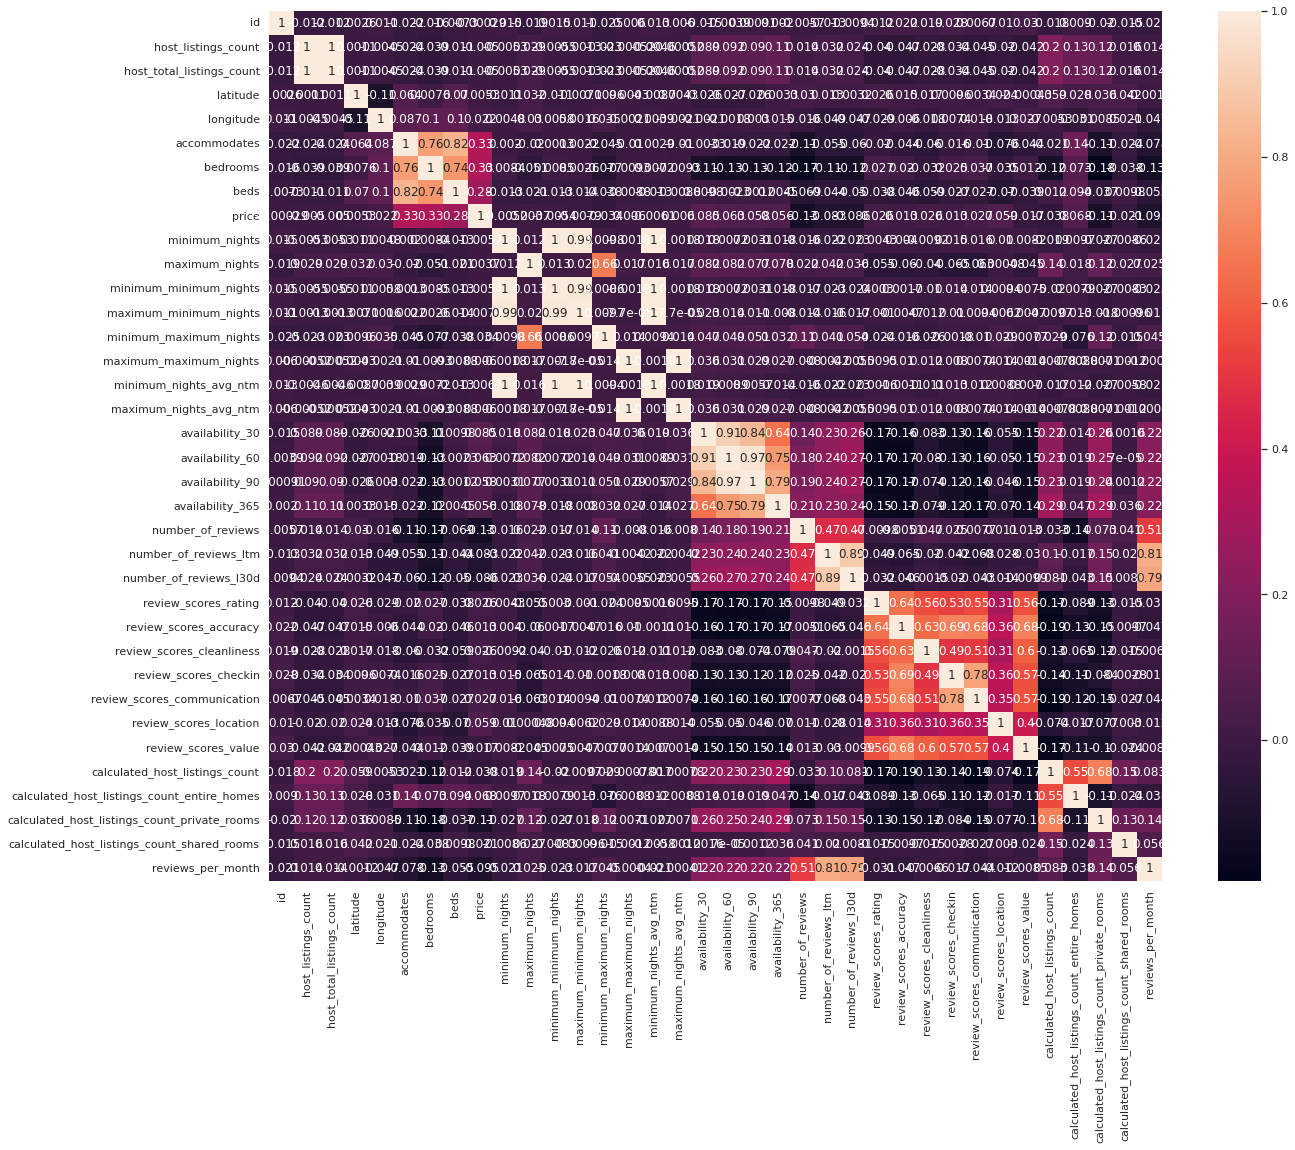

In [26]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (20.,16.)})
sns.set_style("whitegrid")
corrMatrix = train_numeric.corr()
sns.heatmap(corrMatrix, annot=True)

In [27]:
# Aquí elimino las columnas con una correlación mayor de 0,80 así como columnas que considero no aportan valor. Tomadas 
# de la gráfica "feature_importances_".

train_numeric=train_numeric.drop(columns=['host_total_listings_count', 'minimum_minimum_nights', 'maximum_minimum_nights',
                                       'minimum_maximum_nights', 'maximum_maximum_nights', 
                                       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                                       'number_of_reviews_ltm', 'availability_30', 'availability_365', 'availability_60',
                                       'number_of_reviews_l30d', 'beds', 'reviews_per_month', 'review_scores_accuracy',
                                       'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                                        'review_scores_location', 'review_scores_value', 'calculated_host_listings_count_entire_homes', 
                                        'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'])

In [28]:
# I drop these columns in test also.

train=train.drop(columns=['host_total_listings_count', 'minimum_minimum_nights', 'maximum_minimum_nights',
                                'minimum_maximum_nights', 'maximum_maximum_nights', 
                                'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                                'number_of_reviews_ltm', 'availability_30', 'availability_365', 'availability_60',
                                'number_of_reviews_l30d', 'beds', 'reviews_per_month', 'review_scores_accuracy',
                                'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                                'review_scores_location', 'review_scores_value', 'calculated_host_listings_count_entire_homes', 
                                'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'])

<AxesSubplot:>

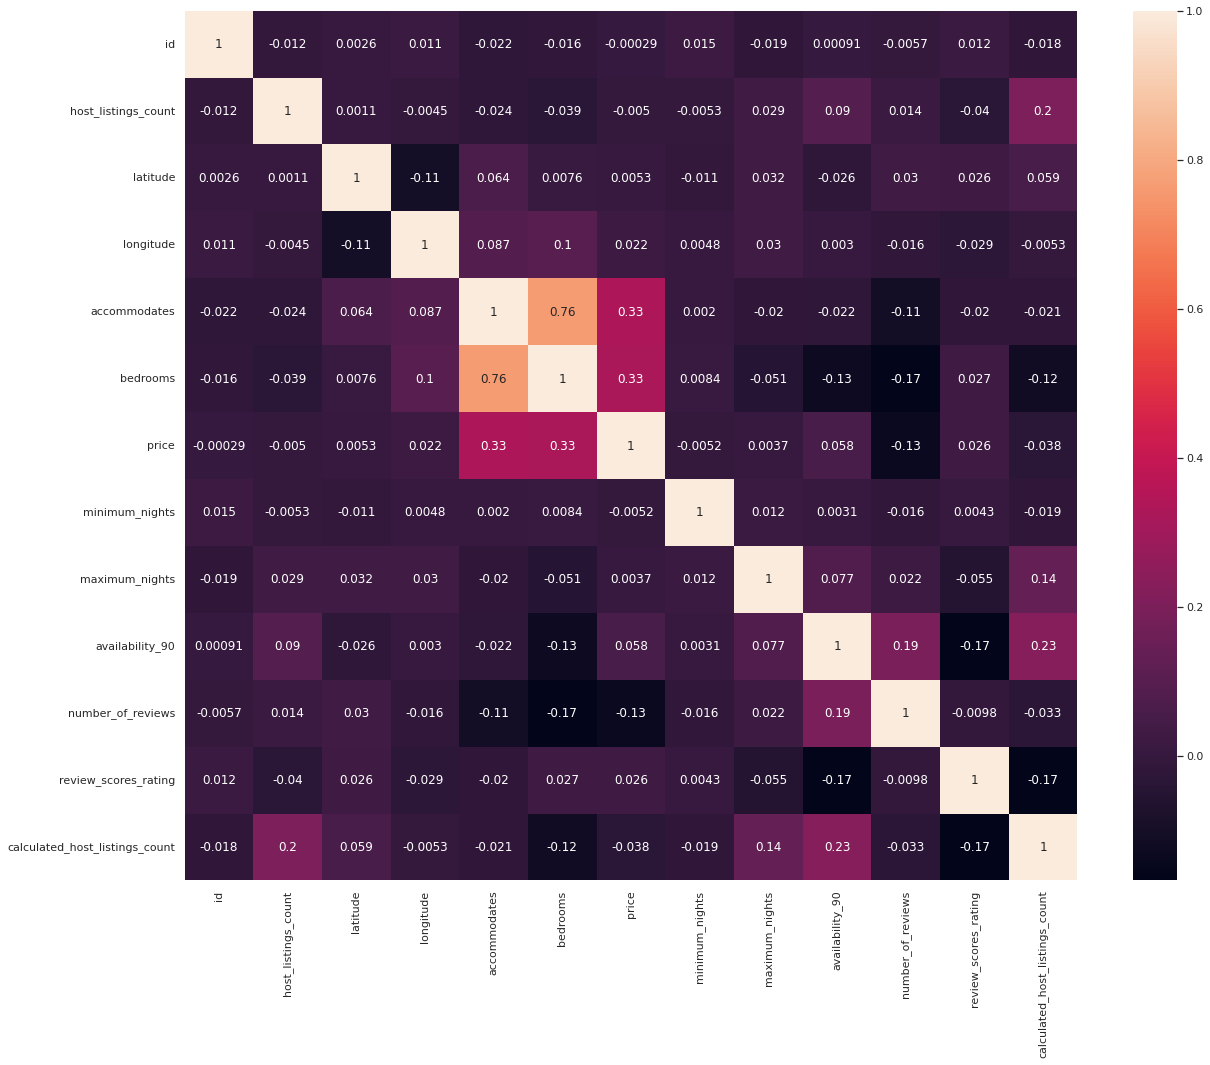

In [29]:
# Matriz de correlación.
sns.set_context("poster")
sns.set(rc={"figure.figsize": (20.,16.)})
sns.set_style("whitegrid")
corrMatrix = train_numeric.corr()
sns.heatmap(corrMatrix, annot=True)

In [30]:
train_numeric.columns

Index(['id', 'host_listings_count', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'price', 'minimum_nights', 'maximum_nights',
       'availability_90', 'number_of_reviews', 'review_scores_rating',
       'calculated_host_listings_count'],
      dtype='object')

In [31]:
train[['id', 'host_listings_count', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'minimum_nights', 'maximum_nights', 'availability_90',
       'number_of_reviews', 'review_scores_rating',
       'calculated_host_listings_count']] = train_numeric[['id', 'host_listings_count', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'minimum_nights', 'maximum_nights', 'availability_90',
       'number_of_reviews', 'review_scores_rating',
       'calculated_host_listings_count']]

In [32]:
train.head(3)

,id,neighborhood_overview,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,...,amenities,price,minimum_nights,maximum_nights,has_availability,availability_90,number_of_reviews,review_scores_rating,instant_bookable,calculated_host_listings_count
0,0,"Waterland is a beautiful countryside area, wit...",f,13,t,t,"Amsterdam, North Holland, Netherlands",Noord-Oost,52.39508,4.99186,...,"[""First aid kit"", ""Free parking on premises"", ...",87.0,2,1125,t,0,81,4.62,f,10
1,1,Our home is located in the Plantagebuurt. A un...,f,0,t,f,"Amsterdam, Noord-Holland, Netherlands",Centrum-Oost,52.36371,4.90745,...,"[""Hot water kettle"", ""Pocket wifi"", ""Stove"", ""...",250.0,2,1125,t,3,9,5.00,f,1
2,2,"The neighbourhood has a quiet, village-like fe...",t,20,t,t,"Amsterdam, Noord-Holland, Netherlands",Zuid,52.35482,4.85329,...,"[""Air conditioning"", ""First aid kit"", ""Hangers...",151.0,1,1125,t,85,47,4.79,t,20


In [33]:
train.replace({'f': 0, 't': 1}, inplace=True)

In [34]:
train.head(3)

,id,neighborhood_overview,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,...,amenities,price,minimum_nights,maximum_nights,has_availability,availability_90,number_of_reviews,review_scores_rating,instant_bookable,calculated_host_listings_count
0,0,"Waterland is a beautiful countryside area, wit...",0,13,1,1,"Amsterdam, North Holland, Netherlands",Noord-Oost,52.39508,4.99186,...,"[""First aid kit"", ""Free parking on premises"", ...",87.0,2,1125,1,0,81,4.62,0,10
1,1,Our home is located in the Plantagebuurt. A un...,0,0,1,0,"Amsterdam, Noord-Holland, Netherlands",Centrum-Oost,52.36371,4.90745,...,"[""Hot water kettle"", ""Pocket wifi"", ""Stove"", ""...",250.0,2,1125,1,3,9,5.00,0,1
2,2,"The neighbourhood has a quiet, village-like fe...",1,20,1,1,"Amsterdam, Noord-Holland, Netherlands",Zuid,52.35482,4.85329,...,"[""Air conditioning"", ""First aid kit"", ""Hangers...",151.0,1,1125,1,85,47,4.79,1,20


In [35]:
train[['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable','bedrooms',
    'has_availability']] = train[['host_is_superhost',
    'host_has_profile_pic','host_identity_verified','instant_bookable','bedrooms',
    'has_availability']].apply(pd.to_numeric,errors='coerce',axis=1)

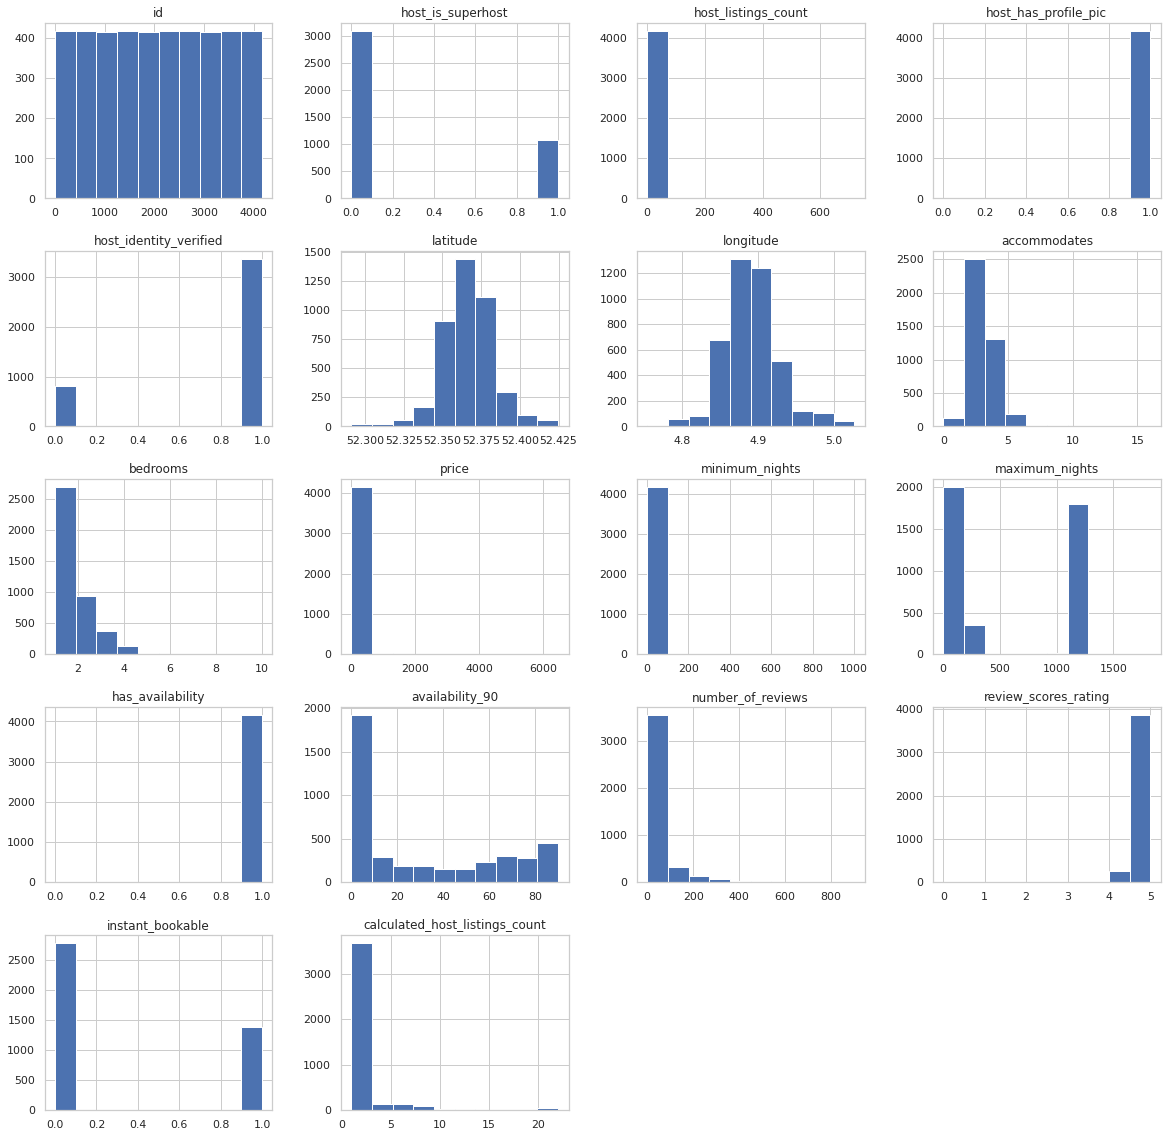

In [36]:
train.hist(figsize=(20,20));
sns.set(rc={"figure.figsize": (20.,20.)})
plt.xticks(size = 0)
plt.yticks(size = 0);

In [37]:
train= train.drop(columns=['has_availability', 'host_has_profile_pic'])

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167 entries, 0 to 4166
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4167 non-null   int64  
 1   neighborhood_overview           3004 non-null   object 
 2   host_is_superhost               4167 non-null   float64
 3   host_listings_count             4167 non-null   int64  
 4   host_identity_verified          4167 non-null   float64
 5   neighbourhood                   3004 non-null   object 
 6   neighbourhood_cleansed          4167 non-null   object 
 7   latitude                        4167 non-null   float64
 8   longitude                       4167 non-null   float64
 9   property_type                   4167 non-null   object 
 10  room_type                       4167 non-null   object 
 11  accommodates                    4167 non-null   int64  
 12  bathrooms_text                  41

In [39]:
train.head(2)

,id,neighborhood_overview,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,...,bedrooms,amenities,price,minimum_nights,maximum_nights,availability_90,number_of_reviews,review_scores_rating,instant_bookable,calculated_host_listings_count
0,0,"Waterland is a beautiful countryside area, wit...",0.0,13,1.0,"Amsterdam, North Holland, Netherlands",Noord-Oost,52.39508,4.99186,Private room in farm stay,...,1.0,"[""First aid kit"", ""Free parking on premises"", ...",87.0,2,1125,0,81,4.62,0.0,10
1,1,Our home is located in the Plantagebuurt. A un...,0.0,0,0.0,"Amsterdam, Noord-Holland, Netherlands",Centrum-Oost,52.36371,4.90745,Entire rental unit,...,2.0,"[""Hot water kettle"", ""Pocket wifi"", ""Stove"", ""...",250.0,2,1125,3,9,5.00,0.0,1


I drop following columns.

In [40]:
train= train.drop(columns=['property_type', 'amenities', 'neighborhood_overview', 'longitude', 'latitude', 'neighbourhood'])

### To clean bathroom_text

In [41]:
# I include in my df the number of bathrooms from "bathrooms_text" in test.

train.bathrooms_text.unique()

array(['1.5 shared baths', '1 bath', '1 private bath', '1.5 baths',
       '2.5 baths', '1 shared bath', '2 baths', '3.5 shared baths',
       '3 baths', 'Half-bath', 'Shared half-bath', '0 baths', nan,
       '4 shared baths', '3.5 baths', '5 baths', '3 shared baths',
       '0 shared baths', '2 shared baths', 'Private half-bath',
       '4.5 baths', '5.5 baths', '4 baths'], dtype=object)

In [42]:
# Función sobre la que posteriormente aplico en las columnas de train y test.
import re

patron='[0-9]+'

def limpieza_ba(x):
    n_ba=0
    
    try:
        n_ba=int(re.findall(patron, x)[0])
    except:
        n_ba=0
        
    return n_ba

train.bathrooms_text.apply(limpieza_ba)[:10]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: bathrooms_text, dtype: int64

In [43]:
train['bathroom']=train.bathrooms_text.apply(limpieza_ba)

In [44]:
train.bathroom.unique()

array([1, 2, 3, 0, 4, 5])

In [45]:
train= train.drop(columns='bathrooms_text')

#### Room_type

In [46]:
train.room_type.unique() 

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

In [47]:
# Tranformo la columna "room_type" en números enteros de la forma que indico abajo.

dict = {'Private room' : 2, 'Entire home/apt' : 4, "Shared room": 1, "Hotel room": 3}
train=train.replace({"room_type": dict})

In [48]:
train['room_type'] = train.room_type

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167 entries, 0 to 4166
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4167 non-null   int64  
 1   host_is_superhost               4167 non-null   float64
 2   host_listings_count             4167 non-null   int64  
 3   host_identity_verified          4167 non-null   float64
 4   neighbourhood_cleansed          4167 non-null   object 
 5   room_type                       4167 non-null   int64  
 6   accommodates                    4167 non-null   int64  
 7   bedrooms                        4167 non-null   float64
 8   price                           4167 non-null   float64
 9   minimum_nights                  4167 non-null   int64  
 10  maximum_nights                  4167 non-null   int64  
 11  availability_90                 4167 non-null   int64  
 12  number_of_reviews               41

In [50]:
train.shape

(4167, 17)

In [51]:
train=pd.get_dummies(data=train,columns=['neighbourhood_cleansed'], drop_first=True)


In [52]:
train= train.astype({'host_is_superhost':'int','host_identity_verified':'int','bedrooms':'int',
              'review_scores_rating':'int','instant_bookable':'int'}) 

In [53]:
train.head(3)

,id,host_is_superhost,host_listings_count,host_identity_verified,room_type,accommodates,bedrooms,price,minimum_nights,maximum_nights,...,neighbourhood_cleansed_Noord-Oost,neighbourhood_cleansed_Noord-West,neighbourhood_cleansed_Oostelijk Havengebied - Indische Buurt,neighbourhood_cleansed_Osdorp,neighbourhood_cleansed_Oud-Noord,neighbourhood_cleansed_Oud-Oost,neighbourhood_cleansed_Slotervaart,neighbourhood_cleansed_Watergraafsmeer,neighbourhood_cleansed_Westerpark,neighbourhood_cleansed_Zuid
0,0,0,13,1,2,3,1,87.0,2,1125,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,4,4,2,250.0,2,1125,...,0,0,0,0,0,0,0,0,0,0
2,2,1,20,1,3,2,1,151.0,1,1125,...,0,0,0,0,0,0,0,0,0,1


In [54]:
train.shape

(4167, 37)

In [55]:
test.shape

(1389, 36)

# Train, test, split

In [56]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse

In [57]:
train.shape

(4167, 37)

In [58]:
X=train.drop('price', axis=1)
y=train.price

In [59]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.05, random_state=64)

In [60]:
from sklearn.feature_selection import SelectFromModel as SFM

In [61]:
modelo=CTR(verbose=0)

selector=SFM(modelo, threshold=0.25)
selector.fit(X_train, y_train)
modelo.fit(X_train, y_train)

In [62]:
def regre(modelo):
    
    modelo.fit(X_train, y_train)
    y_pred=modelo.predict(X_test)
    modelo.fit(X,y)

    train_score=modelo.score(X_train, y_train)  
    test_score=modelo.score(X_test, y_test)
    mean_sq=mean_squared_error(y_test, y_pred, squared=False)
      
    print(modelo)
    print('Train R2:', train_score)
    print('Test R2:', test_score)
    print('rsme:', mean_sq)
   
    return modelo

In [63]:
sgdr=SGDR(max_iter=200)
sgdr=regre(sgdr)

SGDRegressor(max_iter=200)
Train R2: -4.6904687026921843e+24
Test R2: -1.324090262378731e+25
rsme: 330295495155666.06


In [64]:
knnr=KNNR(n_neighbors=5, weights='distance')
knnr=regre(knnr)

KNeighborsRegressor(weights='distance')
Train R2: 1.0
Test R2: 1.0
rsme: 111.97988656554114


In [65]:
gbr=GBR(n_estimators=50, learning_rate=0.2)
gbr=regre(gbr)

GradientBoostingRegressor(learning_rate=0.2, n_estimators=50)
Train R2: 0.7268908459067219
Test R2: 0.6327642618046416
rsme: 70.43303414785805


In [66]:
xgbr=XGBR()
xgbr=regre(xgbr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Train R2: 0.9718898343322122
Test R2: 0.9296284792160315
rsme: 75.51716598712446


In [67]:
ctr=CTR(verbose=0) 
ctr=regre(ctr)

Train R2: 0.9149936775545008
Test R2: 0.7959241299056864
rsme: 76.01094451910566


In [68]:
rfr=RFR(n_estimators=200)
rfr=regre(rfr)

RandomForestRegressor(n_estimators=200)
Train R2: 0.9365079737592081
Test R2: 0.9330181030901624
rsme: 71.77625163606307


In [69]:
rfr.feature_importances_

array([8.39950665e-02, 3.91140557e-03, 5.24103784e-02, 6.39728349e-03,
       8.06588469e-02, 9.93666026e-02, 7.20194027e-02, 2.14104416e-02,
       6.12224738e-02, 7.38662536e-02, 5.53856191e-02, 6.58890509e-03,
       6.68672648e-03, 6.37503829e-02, 1.24910180e-02, 2.42634451e-04,
       6.86686083e-04, 5.16607183e-04, 2.55541261e-01, 1.09661117e-02,
       3.04128212e-03, 2.65193009e-03, 4.76210120e-03, 2.81757064e-04,
       4.65490201e-04, 7.18003756e-04, 9.21088250e-04, 2.14532045e-03,
       8.54777988e-04, 4.03790572e-04, 9.10548059e-03, 1.78614530e-03,
       5.25764471e-04, 6.15751603e-04, 1.72794796e-03, 1.87926145e-03])

<BarContainer object of 36 artists>

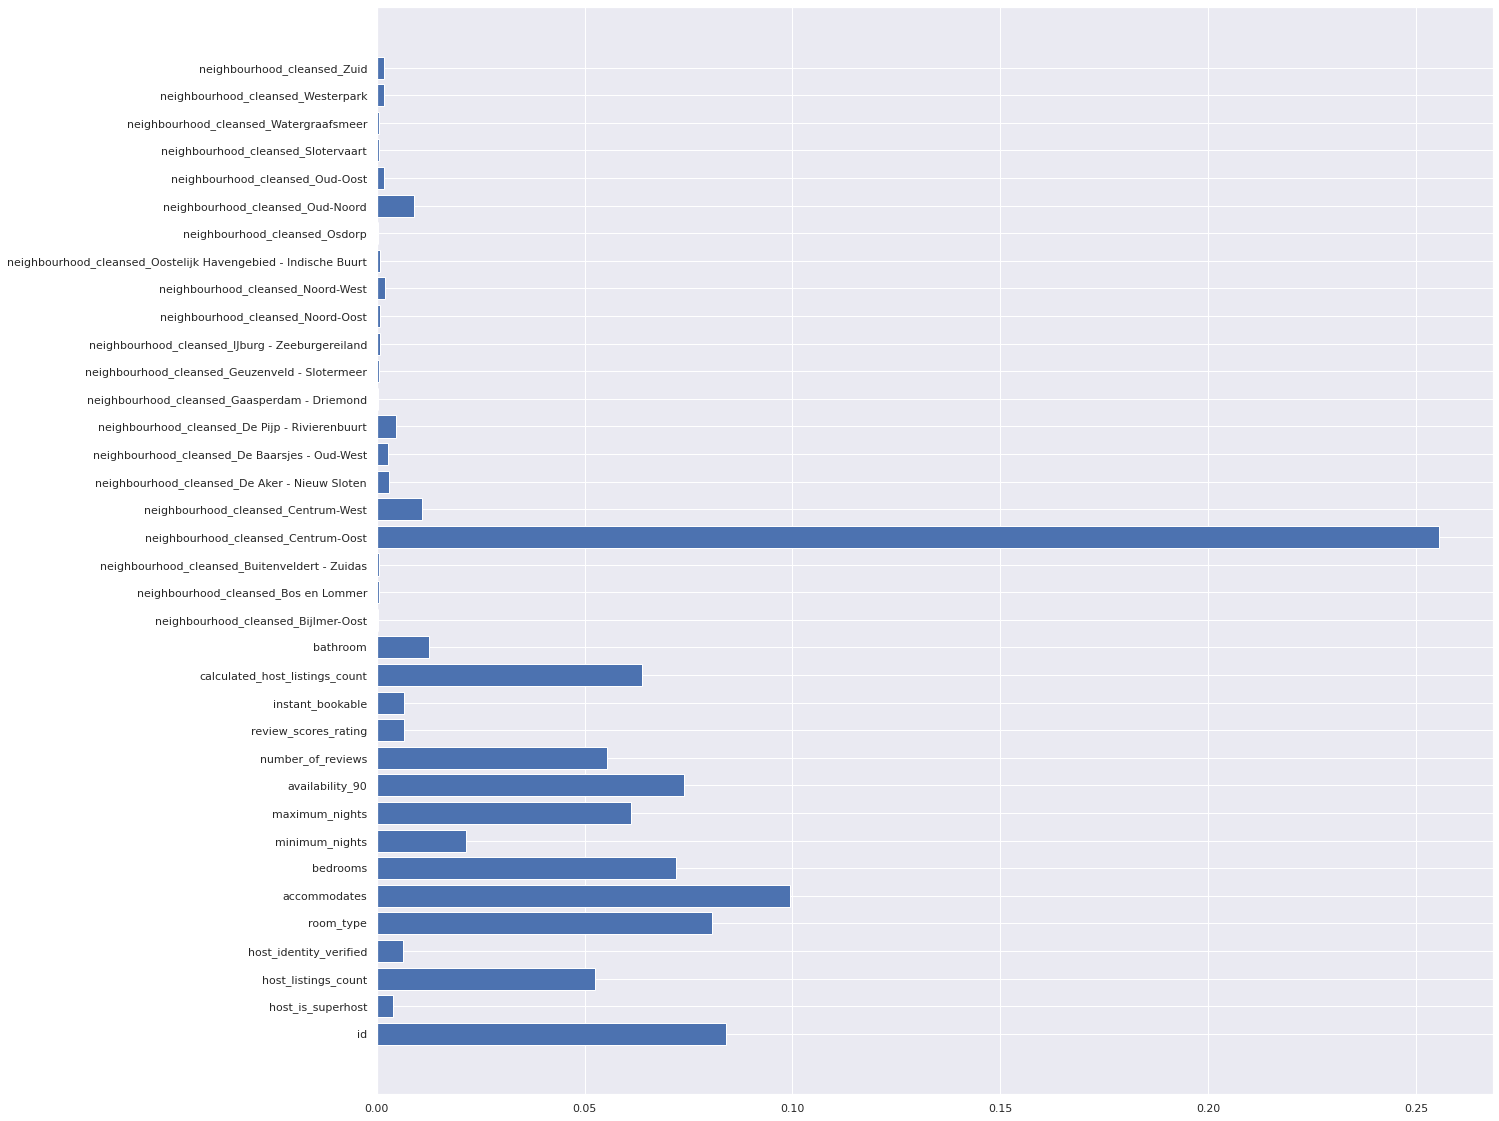

In [70]:
# Matriz de importancia de las columnas con respecto el precio.

plt.barh(X.columns, rfr.feature_importances_)

In [71]:
modelo=ctr
modelo.fit(X_train, y_train)

y_pred=modelo.predict(X_test)

train_score=modelo.score(X_train, y_train)  
test_score=modelo.score(X_test, y_test)
mean_sq=mean_squared_error(y_test, y_pred, squared=False)
    
print(modelo)
print('Train:', train_score)
print('Test:', test_score) 
print('rsme:', mean_sq)
print('\n')

Train: 0.9225545134453513
Test: 0.5000493989586356
rsme: 76.01094451910566




In [72]:
mse(y_pred, y_test, squared=False) # rmse

76.01094451910566

In [73]:
y_pred=modelo.predict(test)

In [74]:
y_pred.shape

(1389,)

In [75]:
submission_df=pd.DataFrame()


submission_df['id']=test['id']
submission_df['price']=y_pred

submission_df.shape

(1389, 2)

In [76]:
submission_df.head()

,id,price
0,0,84.924922
1,1,41.446476
2,2,102.323886
3,3,116.072078
4,4,78.270123


In [77]:
submission_df.to_csv('prediccion.csv', index=False, header=True)

In [78]:
# Aquí lo que hago es mirar diferentes modelos y ver cual tiene mejor performance.
dict_fit ={}

In [79]:
modelos=[LinReg(), Lasso(), Ridge(), ElasticNet(), SVR(), SGDR(), RFR(), KNNR(), GBR(), DTR()]

In [80]:
def regre(modelo):
    
    modelo.fit(X_train, y_train)
    
    train_score=modelo.score(X_train, y_train)  # R2
    test_score=modelo.score(X_test, y_test)
    
    print(modelo)
    print('Train R2:', train_score)
    print('Test R2:', test_score)
    
    return modelo

In [81]:
for i, e in enumerate(modelos):
    dict_fit[regre(e)] = (train_score, test_score)

LinearRegression()
Train R2: 0.17386990333536156
Test R2: 0.5555162476269008
Lasso()
Train R2: 0.16545150972088163
Test R2: 0.5513996959872112
Ridge()
Train R2: 0.17381383482318213
Test R2: 0.5648135072340816
ElasticNet()
Train R2: 0.1457805533409201
Test R2: 0.4938795007874851
SVR()
Train R2: -0.029688303468715205
Test R2: -0.06886792249938178
SGDRegressor()
Train R2: -7.841428316690833e+25
Test R2: -2.2351995100967965e+26
RandomForestRegressor()
Train R2: 0.9140009392159448
Test R2: 0.532652474912506
KNeighborsRegressor()
Train R2: 0.24781998682959383
Test R2: -0.0903775460910583
GradientBoostingRegressor()
Train R2: 0.6966942715730382
Test R2: 0.5945283372577386
DecisionTreeRegressor()
Train R2: 1.0
Test R2: 0.3088661513419876
